Tutorial:
https://ecmwf-projects.github.io/copernicus-training-c3s/reanalysis-climatology.html

Data:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-extreme-indices-cmip6?tab=form

In [17]:
# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr
import netCDF4
import h5netcdf

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

In [18]:
WBGT_day_hist = f'../Climate_Data/download/WBGT_day_EC-Earth3_historical_r1i1p1f1_bias-adj_v20200310_19510101-20101231_v2-0.nc'
WBGT_day_proj = f'../Climate_Data/download/WBGT_day_EC-Earth3_ssp245_r1i1p1f1_bias-adj_v20200310_20110101-21001231_v2-0.nc'

# 1. View Data

In [19]:
ds_hist = xr.open_dataset(WBGT_day_hist)
ds_proj = xr.open_dataset(WBGT_day_proj)

In [20]:
ds_hist

<xarray.Dataset> Size: 11GB
Dimensions:  (time: 21915, lon: 512, lat: 256)
Coordinates:
  * time     (time) datetime64[ns] 175kB 1951-01-01 1951-01-02 ... 2010-12-31
  * lon      (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
  * lat      (lat) float64 2kB -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
Data variables:
    WBGT     (time, lat, lon) float32 11GB ...
Attributes: (12/78)
    CDI_grid_num_LPE:                    128
    CDI_grid_type:                       gaussian
    ba_anonymous_dimension_name:         None
    ba_detrend:                          1
    ba_fill_value:                       1e+20
    ba_halfwin_upper_bound_climatology:  0
    ...                                  ...
    cmor_version:                        3.5.0
    tracking_id:                         hdl:21.14100/6e22f555-927a-4c1d-ae11...
    branch_time_in_child:                0.0D
    branch_time_in_parent:               149749.0D
    HSI_institution:                     Center for International Climate and...
    HSI_institution_ID:                  CICERO

In [21]:
ds_180_hist = ds_hist.assign_coords(lon=(((ds_hist.lon + 180) % 360) - 180)).sortby('lon')
ds_180_proj = ds_proj.assign_coords(lon=(((ds_proj.lon + 180) % 360) - 180)).sortby('lon')

In [22]:
ds_180_hist.lon

<xarray.DataArray 'lon' (lon: 512)> Size: 4kB
array([-180.      , -179.296875, -178.59375 , ...,  177.890625,  178.59375 ,
        179.296875])
Coordinates:
  * lon      (lon) float64 4kB -180.0 -179.3 -178.6 -177.9 ... 177.9 178.6 179.3

In [23]:
da_hist = ds_180_hist['WBGT']
da_proj = ds_180_proj['WBGT']

In [168]:
da_hist

<xarray.DataArray 'WBGT' (time: 21915, lat: 256, lon: 512)> Size: 11GB
[2872442880 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 175kB 1951-01-01 1951-01-02 ... 2010-12-31
  * lat      (lat) float64 2kB -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 4kB -180.0 -179.3 -178.6 -177.9 ... 177.9 178.6 179.3
Attributes:
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  128
    units:             degrees_C
    long_name:         Wet bulb globe temperature

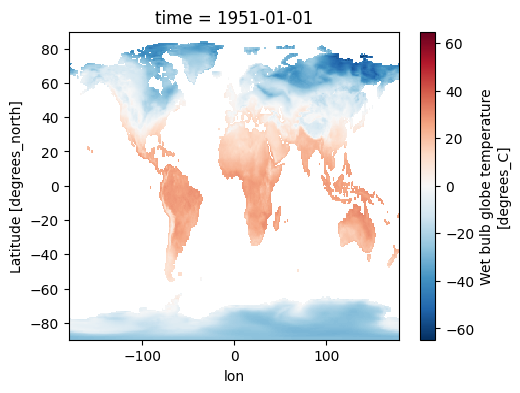

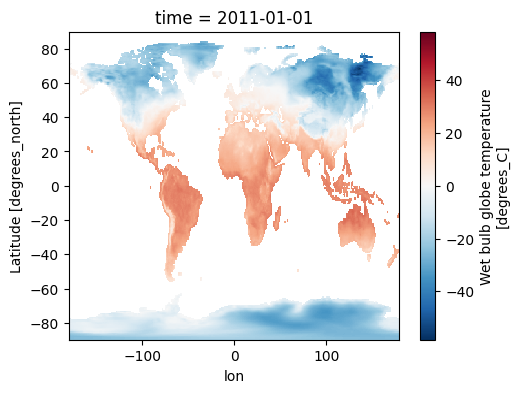

In [31]:
da_hist[0,:,:].plot(size=4)
da_proj[0,:,:].plot(size=4)

# 2. Calculate Climate Normals

In [25]:
hist_yearly_mean = da_hist.groupby('time.year').mean(keep_attrs=True)
proj_yearly_mean = da_proj.groupby('time.year').mean(keep_attrs=True)

In [26]:
hist_ref = hist_yearly_mean.where((hist_yearly_mean.year > 1980) & (hist_yearly_mean.year < 2011), drop=True)
proj_ref = proj_yearly_mean.where((proj_yearly_mean.year > 2060) & (proj_yearly_mean.year < 2091), drop=True)

In [27]:
hist_ref_mean = hist_ref.mean(dim="year", keep_attrs=True)
proj_ref_mean = proj_ref.mean(dim="year", keep_attrs=True)

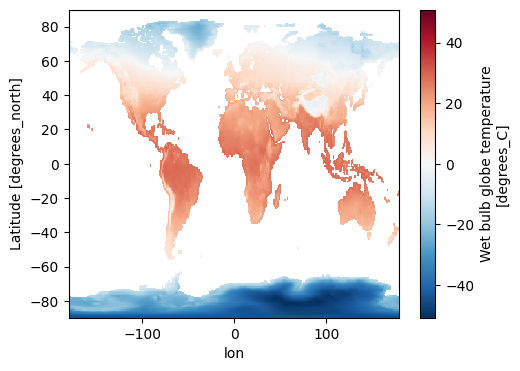

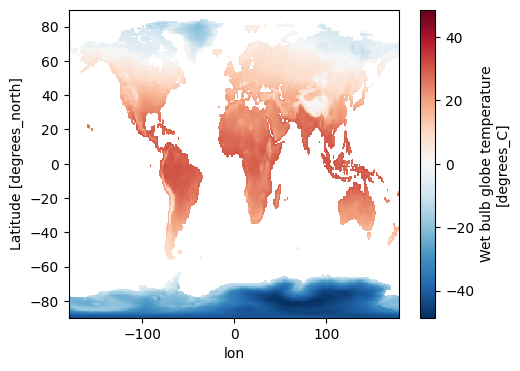

In [32]:
hist_ref_mean[:,:].plot(size=4)
proj_ref_mean[:,:].plot(size=4)

In [33]:
proj_hist = proj_ref_mean - hist_ref_mean

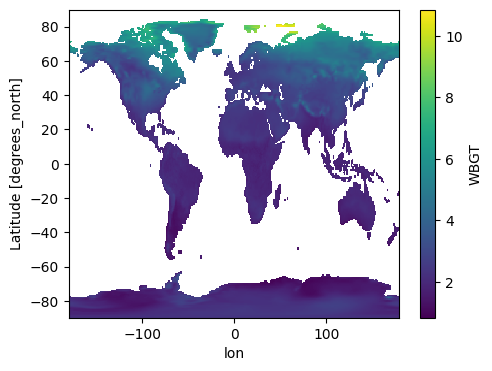

In [34]:
proj_hist[:,:].plot(size=4)

# 3. Anomaly Calculation

In [35]:
hist_yearly_mean_1996 = hist_yearly_mean.sel(year=1996)

In [41]:
anom_1996 = hist_yearly_mean_1996 - hist_ref_mean

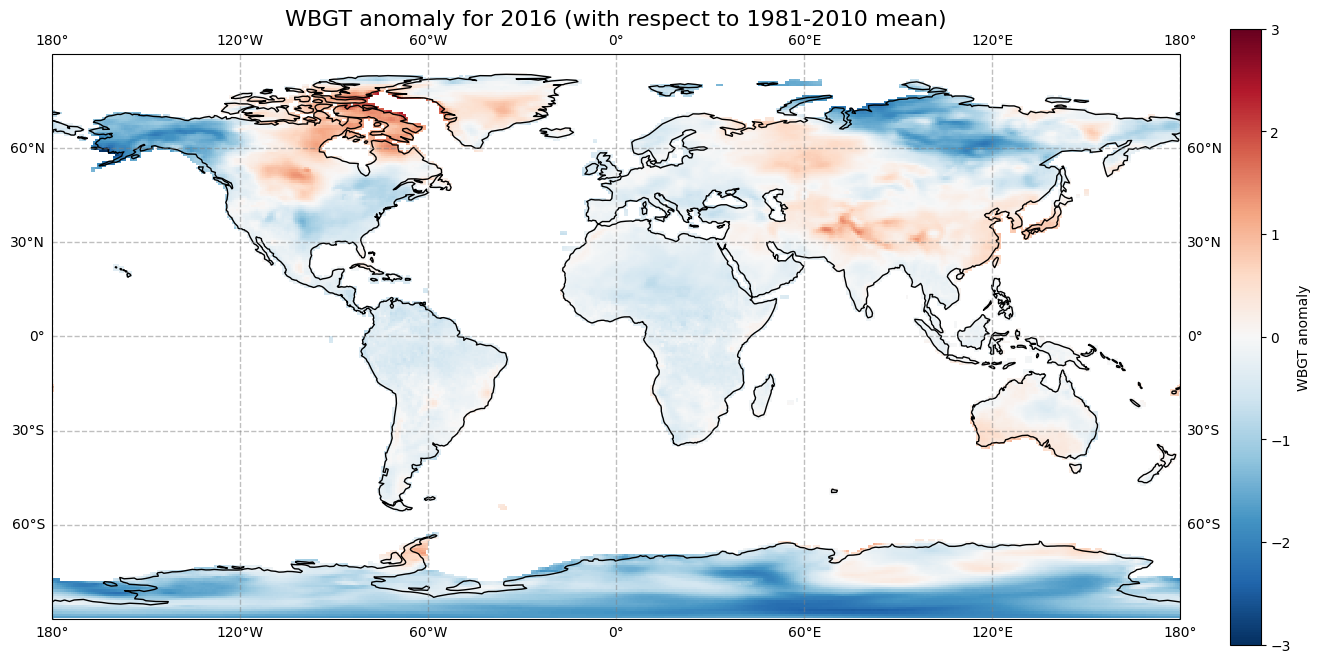

In [42]:
# create the figure panel and the map using the Cartopy PlateCarree projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(anom_1996.lon, anom_1996.lat, anom_1996, cmap='RdBu_r', vmin=-3, vmax=3) 

# Set the figure title, add lat/lon grid and coastlines
ax.set_title('WBGT anomaly for 2016 (with respect to 1981-2010 mean)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('WBGT anomaly') 

# Save the figure
#fig.savefig(f'{DATADIR}ERA5_global_2016_anomaly_world.png')

In [43]:
proj_yearly_mean_2076 = proj_yearly_mean.sel(year=2076)

In [44]:
anom_2076 = proj_yearly_mean_2076 - hist_ref_mean

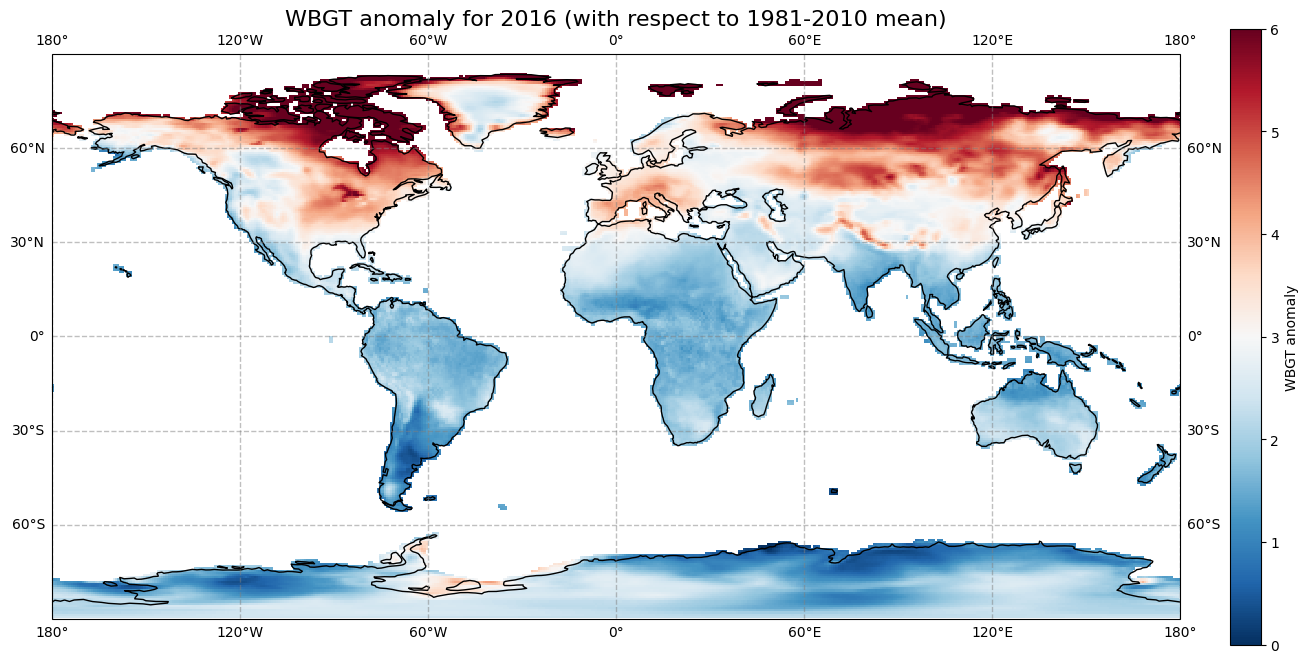

In [46]:
# create the figure panel and the map using the Cartopy PlateCarree projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(anom_2076.lon, anom_2076.lat, anom_2076, cmap='RdBu_r', vmin=0, vmax=6) 

# Set the figure title, add lat/lon grid and coastlines
ax.set_title('WBGT anomaly for 2016 (with respect to 1981-2010 mean)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('WBGT anomaly') 

# Save the figure
#fig.savefig(f'{DATADIR}ERA5_global_2016_anomaly_world.png')

# 4. Calculate monthly climatology and anomalies

In [61]:
clim_period_hist = da_hist.sel(time=slice('1981-01-01', '2010-12-01'))
clim_period_proj = da_proj.sel(time=slice('2061-01-01', '2090-12-01'))

In [89]:
clim_month_hist = clim_period_hist.groupby('time.month').mean()
clim_month_proj = clim_period_proj.groupby('time.month').mean()

Let us view this monthly climatology averaged over the entire European region. To do this we need to average over the latitude and longitude dimensions. A very important consideration however is that the gridded data cells do not all correspond to the same areas. The size covered by each data point varies as a function of latitude. We need to take this into account when averaging. One way to do this is to use the cosine of the latitude as a proxy for the varying sizes.

In [90]:
weights = np.cos(np.deg2rad(clim_month_hist.lat))
weights.name = "weights"
clim_month_hist_weighted = clim_month_hist.weighted(weights)
clim_month_proj_weighted = clim_month_proj.weighted(weights)

In [91]:
mean_hist = clim_month_hist_weighted.mean(["lon", "lat"])
mean_proj = clim_month_proj_weighted.mean(["lon", "lat"])

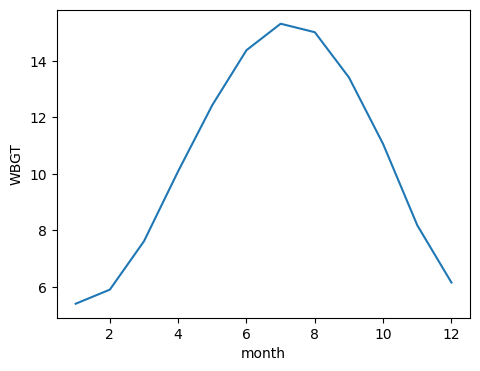

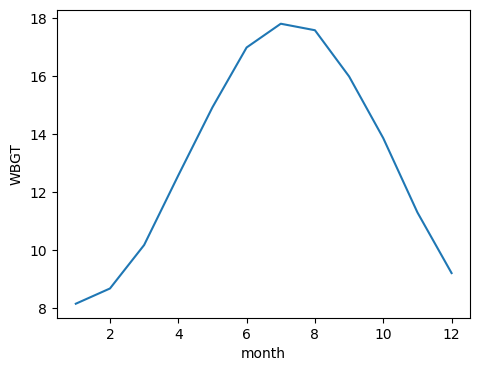

In [92]:
mean_hist.plot(size=4)
mean_proj.plot(size=4)

In [93]:
#from daily data to monthly average data before computing standard deviation over years
clim_period_hist_m = clim_period_hist.resample(time='1m').mean(dim='time')
clim_period_proj_m = clim_period_proj.resample(time='1m').mean(dim='time')

clim_std_hist = clim_period_hist_m.groupby('time.month').std()
clim_std_proj = clim_period_proj_m.groupby('time.month').std()

weights = np.cos(np.deg2rad(clim_std_hist.lat))
weights.name = "weights"
clim_std_hist_weighted = clim_std_hist.weighted(weights)
clim_std_proj_weighted = clim_std_proj.weighted(weights)

std_hist = clim_std_hist_weighted.mean(["lon", "lat"])
std_proj = clim_std_proj_weighted.mean(["lon", "lat"])

/Users/arnaudgoussebaile/.pyenv/versions/copernicus-env/lib/python3.10/site-packages/xarray/groupers.py:326: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/Users/arnaudgoussebaile/.pyenv/versions/copernicus-env/lib/python3.10/site-packages/xarray/groupers.py:326: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/Users/arnaudgoussebaile/.pyenv/versions/copernicus-env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/arnaudgoussebaile/.pyenv/versions/copernicus-env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/arnaudgoussebaile/.pyenv/versions/c

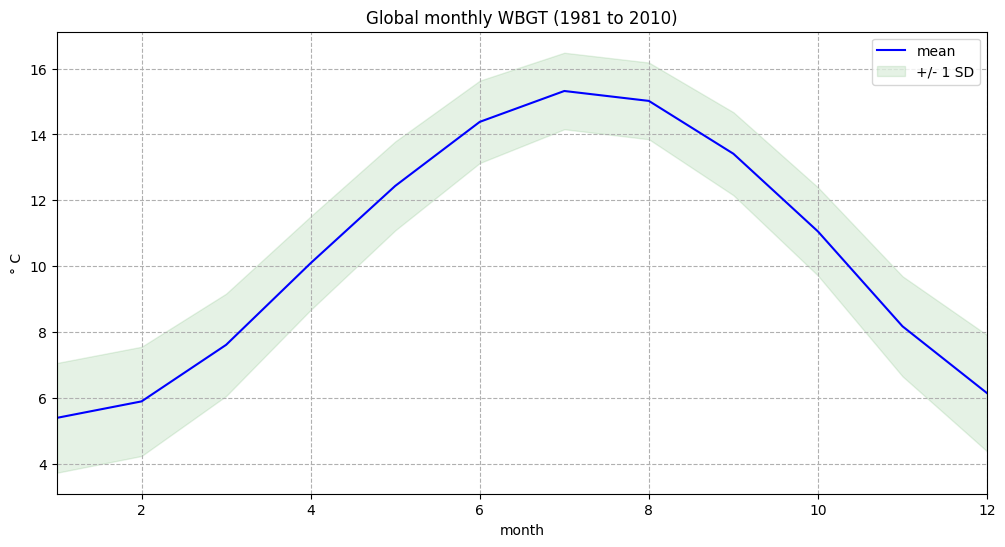

In [94]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.plot(mean_hist.month, mean_hist, color='blue', label='mean')
ax.fill_between(mean_hist.month, (mean_hist + std_hist), (mean_hist - std_hist), alpha=0.1, color='green', label='+/- 1 SD')

ax.set_title('Global monthly WBGT (1981 to 2010)')
ax.set_ylabel('° C')
ax.set_xlabel('month')
ax.set_xlim(1,12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

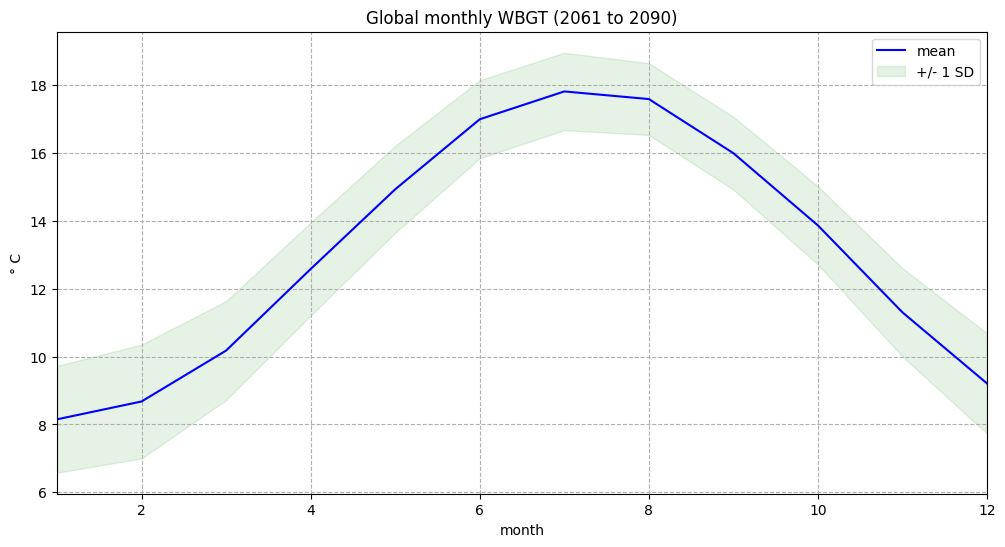

In [95]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.plot(mean_proj.month, mean_proj, color='blue', label='mean')
ax.fill_between(mean_proj.month, (mean_proj + std_proj), (mean_proj - std_proj), alpha=0.1, color='green', label='+/- 1 SD')

ax.set_title('Global monthly WBGT (2061 to 2090)')
ax.set_ylabel('° C')
ax.set_xlabel('month')
ax.set_xlim(1,12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

In [97]:
anom_month_hist = clim_period_hist_m.groupby('time.month') - clim_month_hist
anom_month_proj = clim_period_proj_m.groupby('time.month') - clim_month_hist

In [98]:
anom_aug_hist = anom_month_hist[anom_month_hist.month == 8]
anom_aug_proj = anom_month_proj[anom_month_proj.month == 8]

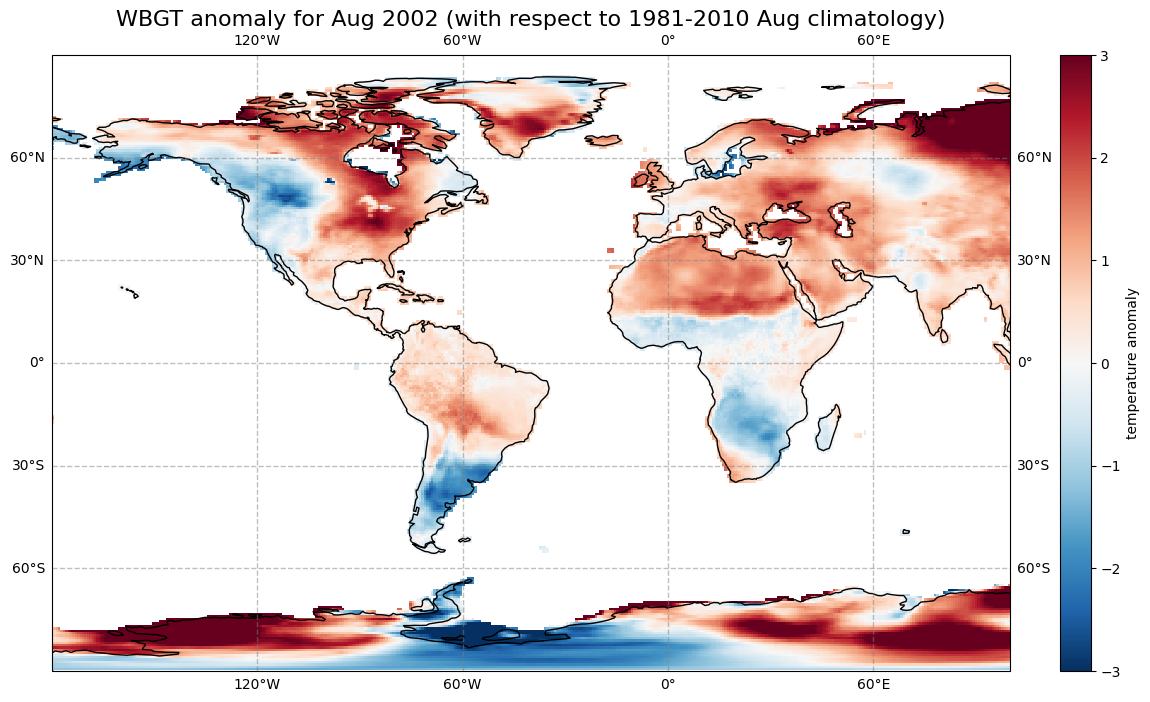

In [99]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

im = plt.pcolormesh(anom_aug_hist.lon, anom_aug_hist.lat, anom_aug_hist[21,:,:], cmap='RdBu_r', vmin=-3, vmax=3) 

ax.set_title('WBGT anomaly for Aug 2002 (with respect to 1981-2010 Aug climatology)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-180, 100, -90, 90], crs=ccrs.PlateCarree())

cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature anomaly') 

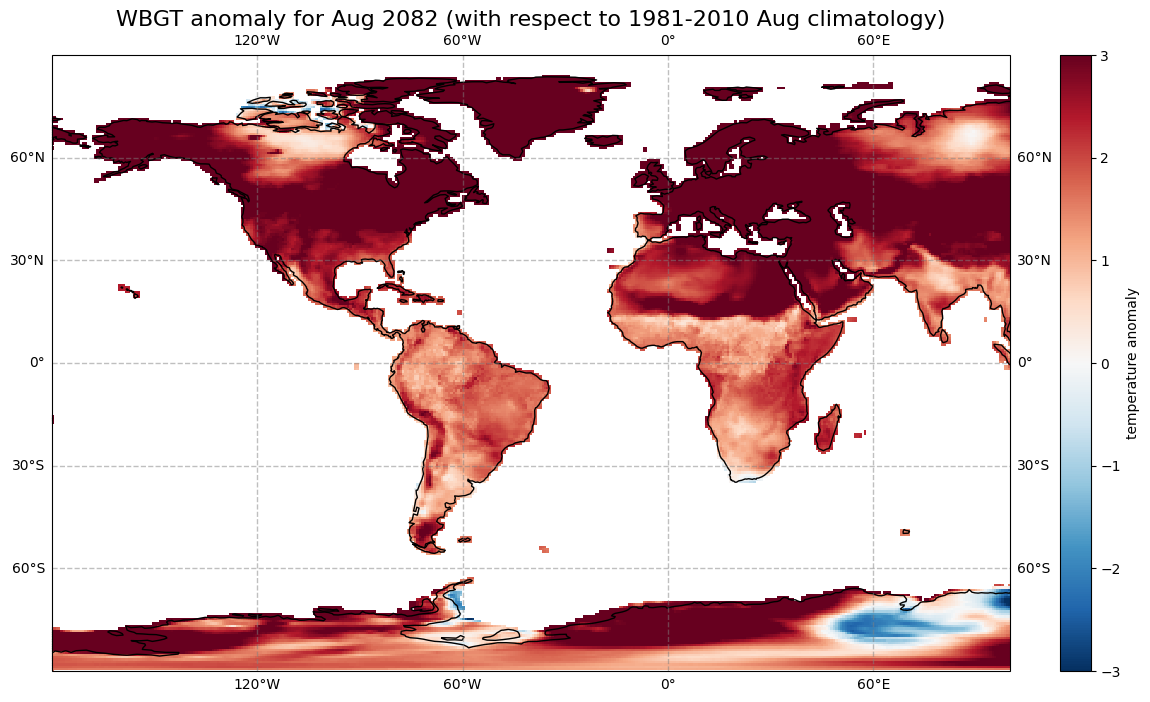

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

im = plt.pcolormesh(anom_aug_proj.lon, anom_aug_proj.lat, anom_aug_proj[21,:,:], cmap='RdBu_r', vmin=-3, vmax=3) 

ax.set_title('WBGT anomaly for Aug 2082 (with respect to 1981-2010 Aug climatology)', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-180, 100, -90, 90], crs=ccrs.PlateCarree())

cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature anomaly') 

# 5. Time series analysis

### Yearly WBGT

In [101]:
clim_year_hist = clim_period_hist.groupby('time.year').mean()
clim_year_proj = clim_period_proj.groupby('time.year').mean()

In [102]:
weights = np.cos(np.deg2rad(clim_year_hist.lat))
weights.name = "weights"
clim_year_hist_weighted = clim_year_hist.weighted(weights)
clim_year_proj_weighted = clim_year_proj.weighted(weights)
yearly_mean_hist = clim_year_hist_weighted.mean(["lon", "lat"])
yearly_mean_proj = clim_year_proj_weighted.mean(["lon", "lat"])

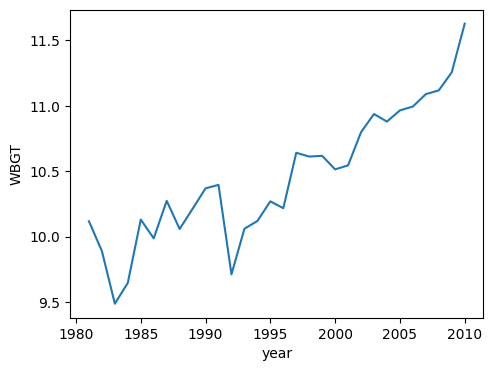

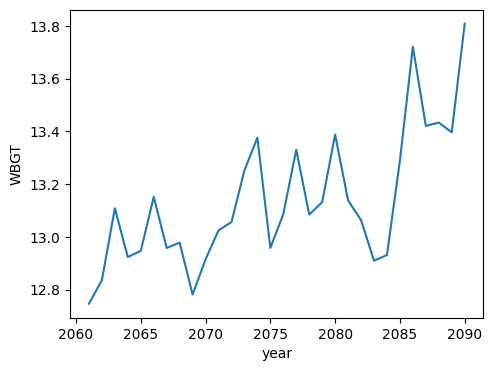

In [103]:
yearly_mean_hist.plot(size=4)
yearly_mean_proj.plot(size=4)

In [104]:
WBGT_ref_hist = yearly_mean_hist.mean()
yearly_anom_hist = yearly_mean_hist - WBGT_ref_hist
yearly_anom_proj = yearly_mean_proj - WBGT_ref_hist

In [115]:
df_hist = yearly_anom_hist.to_dataframe()
df_hist['positive'] = df_hist['WBGT'] > 0
df_proj = yearly_anom_proj.to_dataframe()
df_proj['positive'] = df_proj['WBGT'] > 0
df_hist.head() # show only first five rows

,WBGT,positive
year,,
1981,-0.333686,False
1982,-0.561304,False
1983,-0.963676,False
1984,-0.804537,False
1985,-0.320820,False


<Axes: title={'center': '\nYearly anomalies of WBGT (reference period 1981-2010)\n'}, xlabel='\nYear', ylabel='Temperature Anomaly'>

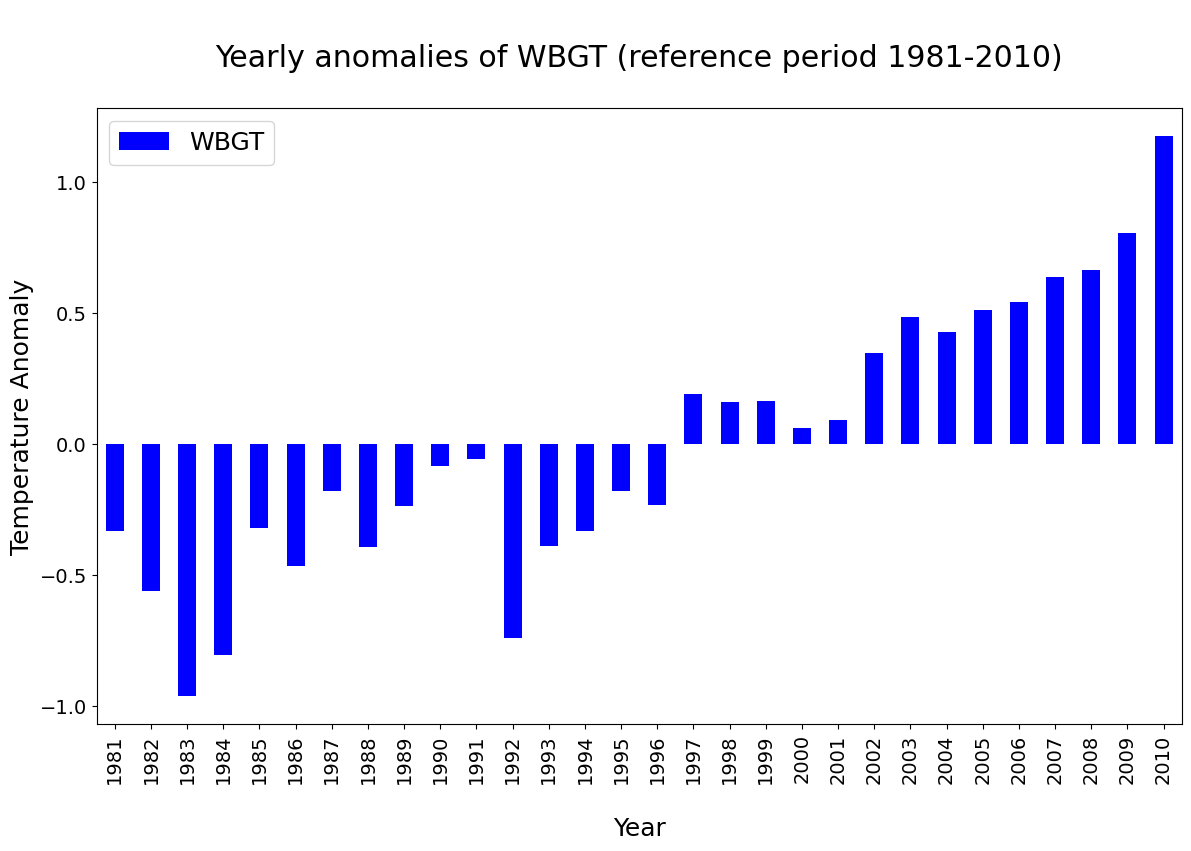

In [116]:
plt.rcParams.update({'font.size': 18}) # must set in top
df_hist.plot(
    figsize=(14,8),
    kind='bar',
    color=df_hist.positive.map({True: 'red', False: 'blue'}),
    fontsize=14,
    xlabel='\nYear',
    ylabel='Temperature Anomaly',
    title='\nYearly anomalies of WBGT (reference period 1981-2010)\n',
    )
#plt.savefig(f'{DATADIR}WBGT_anom_bar.png')

<Axes: title={'center': '\nYearly anomalies of WBGT (reference period 1981-2010)\n'}, xlabel='\nYear', ylabel='Temperature Anomaly'>

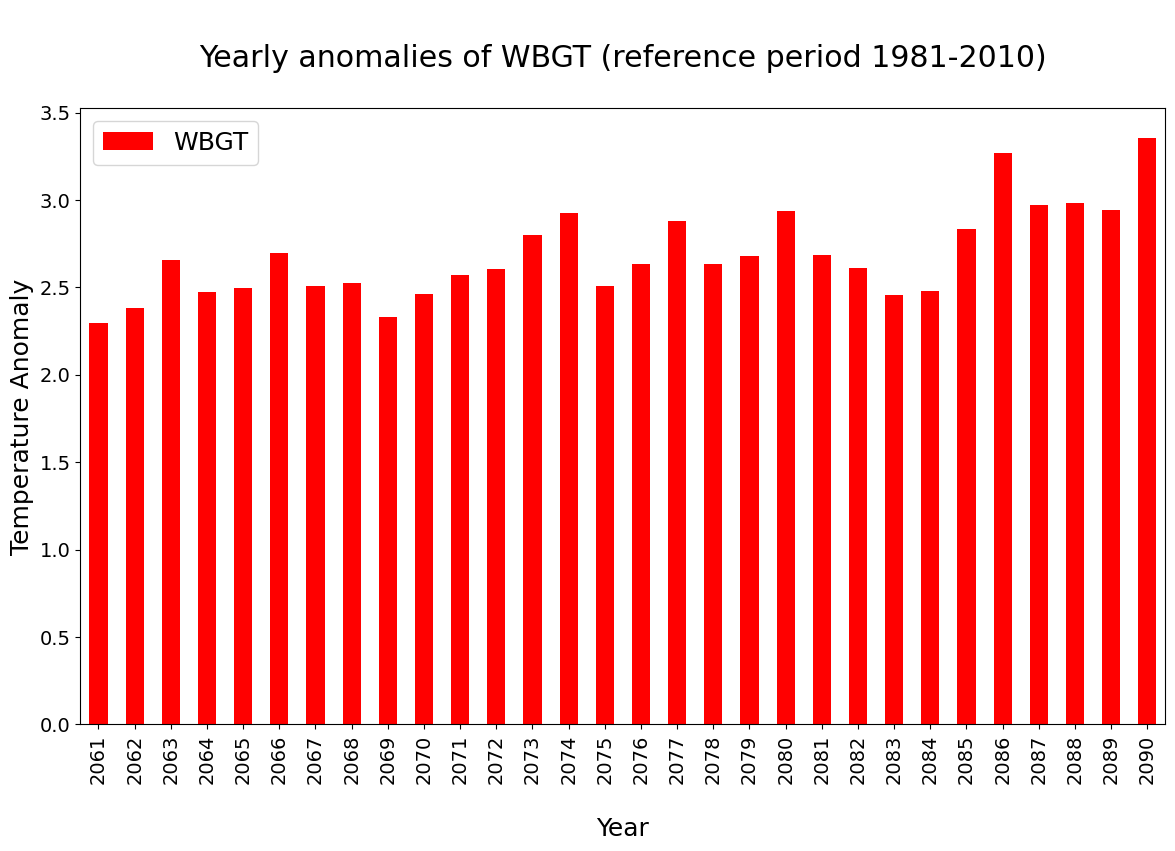

In [118]:
plt.rcParams.update({'font.size': 18}) # must set in top
df_proj.plot(
    figsize=(14,8),
    kind='bar',
    color=df_proj.positive.map({True: 'red', False: 'blue'}),
    fontsize=14,
    xlabel='\nYear',
    ylabel='Temperature Anomaly',
    title='\nYearly anomalies of WBGT (reference period 1981-2010)\n',
    )
#plt.savefig(f'{DATADIR}WBGT_anom_bar.png')

### Quarterly WBGT

In [119]:
clim_period_hist_q = clim_period_hist.resample(time='QS-DEC').mean(dim='time')
clim_period_proj_q = clim_period_proj.resample(time='QS-DEC').mean(dim='time')

In [123]:
north_clim_period_hist_q = clim_period_hist_q.where(clim_period_hist_q.lat > 0, drop=True)
north_clim_period_proj_q = clim_period_proj_q.where(clim_period_hist_q.lat > 0, drop=True)

In [125]:
weights = np.cos(np.deg2rad(north_clim_period_hist_q.lat))
weights.name = "weights"
north_clim_period_hist_q_weighted = north_clim_period_hist_q.weighted(weights)
north_clim_period_proj_q_weighted = north_clim_period_proj_q.weighted(weights)
north_quaterly_mean_hist = north_clim_period_hist_q_weighted.mean(["lon", "lat"])
north_quaterly_mean_proj = north_clim_period_proj_q_weighted.mean(["lon", "lat"])

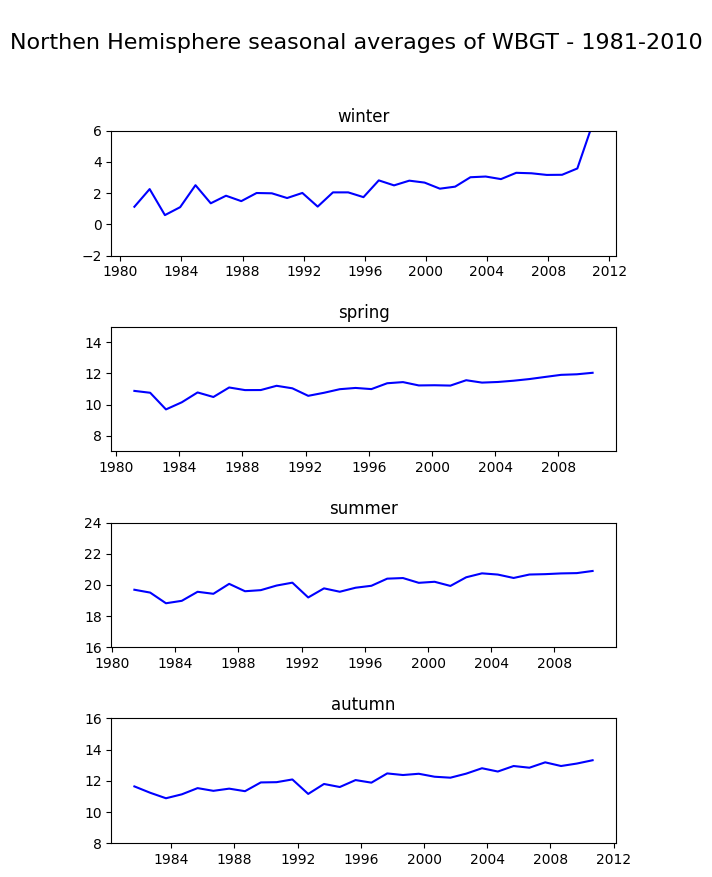

In [127]:
fig, axs = plt.subplots(4, 1, figsize = (6, 9))

season_list = ["winter", "spring", "summer", "autumn"]

for i in range(4):
    df = north_quaterly_mean_hist[i::4].to_dataframe()
    mid_range = np.around(df.mean().values)
    axs[i].plot(df.WBGT, color='blue')
    axs[i].set_ylim([mid_range[0]-4, mid_range[0]+4])
    axs[i].set_title(season_list[i], fontsize=12)
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)

fig.suptitle('\nNorthen Hemisphere seasonal averages of WBGT - 1981-2010\n', fontsize=16)
fig.tight_layout(pad=1.0)

#fig.savefig(f'{DATADIR}World_seasonal.png')

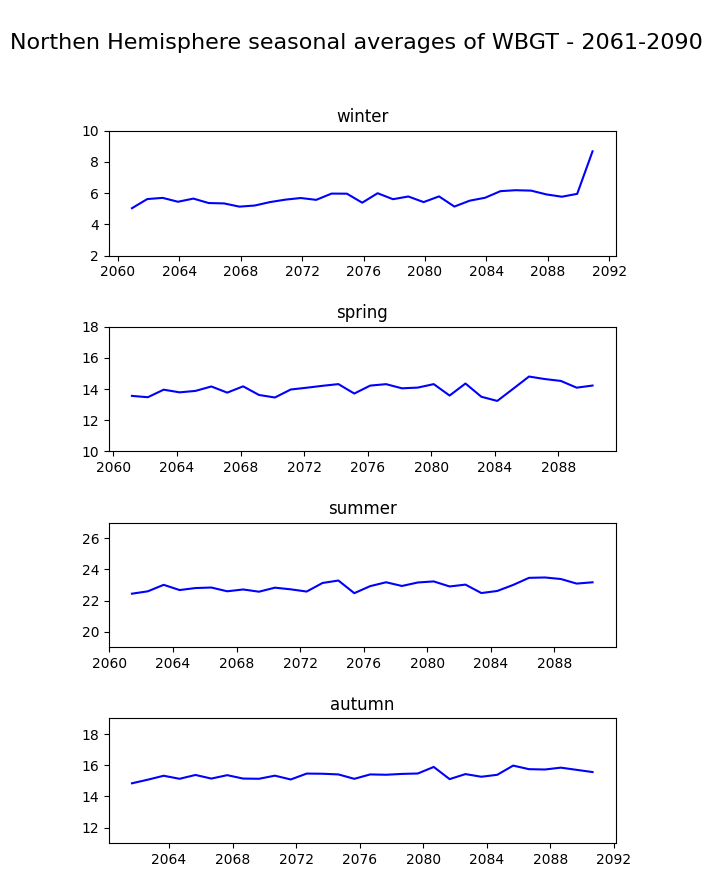

In [128]:
fig, axs = plt.subplots(4, 1, figsize = (6, 9))

season_list = ["winter", "spring", "summer", "autumn"]

for i in range(4):
    df = north_quaterly_mean_proj[i::4].to_dataframe()
    mid_range = np.around(df.mean().values)
    axs[i].plot(df.WBGT, color='blue')
    axs[i].set_ylim([mid_range[0]-4, mid_range[0]+4])
    axs[i].set_title(season_list[i], fontsize=12)
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)

fig.suptitle('\nNorthen Hemisphere seasonal averages of WBGT - 2061-2090\n', fontsize=16)
fig.tight_layout(pad=1.0)

#fig.savefig(f'{DATADIR}World_seasonal.png')

# 6. Distribution of WBGT

In [162]:
da_hist_period = da_hist.sel(time=slice('1990-01-01', '1999-12-01'))
da_proj_period = da_proj.sel(time=slice('2070-01-01', '2079-12-01'))

In [191]:
da_hist_period_values = da_hist_period[:,195,260].values
da_proj_period_values = da_proj_period[:,195,260].values

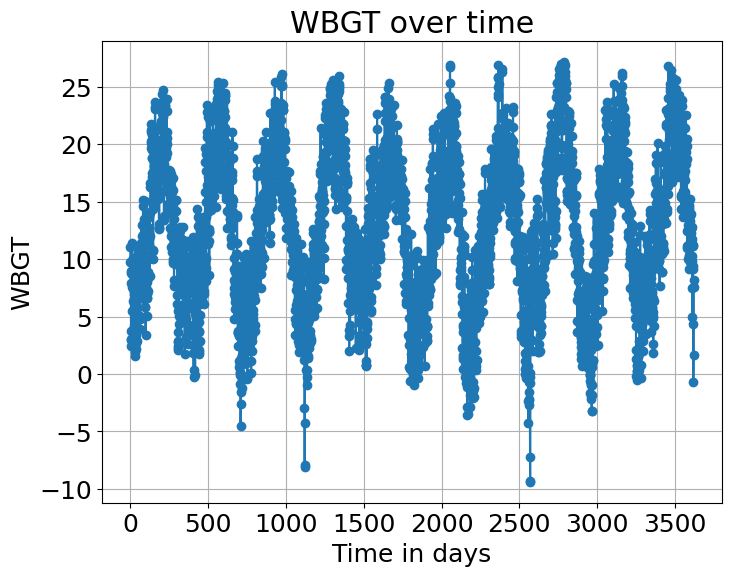

In [192]:
plt.figure(figsize=(8, 6))
plt.plot(da_hist_period_values, marker='o')
plt.title('WBGT over time')
plt.xlabel('Time in days')
plt.ylabel('WBGT')
plt.grid(True)
plt.show()

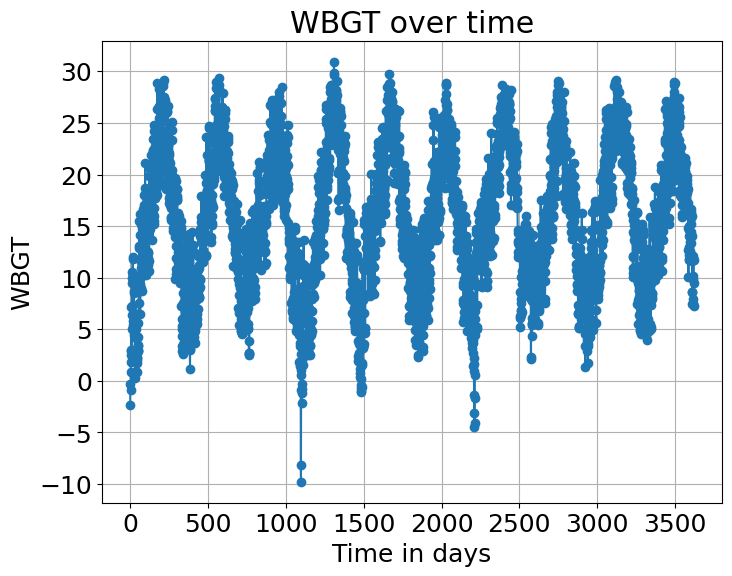

In [193]:
plt.figure(figsize=(8, 6))
plt.plot(da_proj_period_values, marker='o')
plt.title('WBGT over time')
plt.xlabel('Time in days')
plt.ylabel('WBGT')
plt.grid(True)
plt.show()

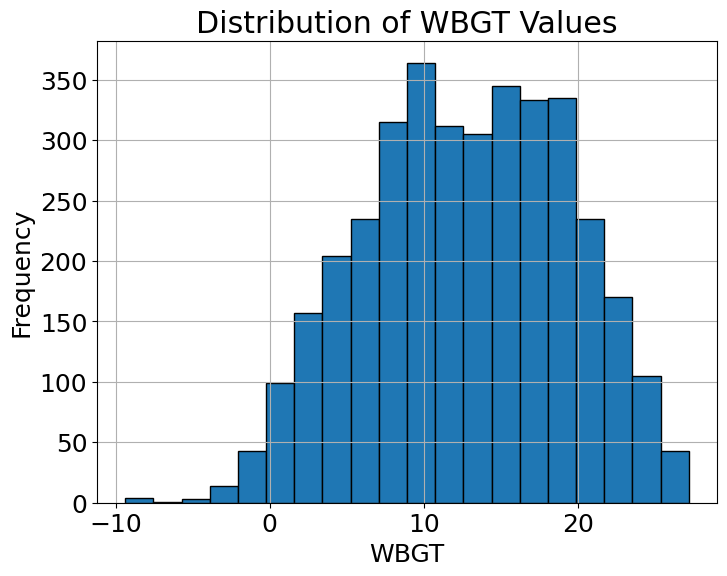

In [194]:
plt.figure(figsize=(8, 6))
plt.hist(da_hist_period_values, bins=20, edgecolor='black')  # Adjust number of bins as needed
plt.title('Distribution of WBGT Values')
plt.xlabel('WBGT')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

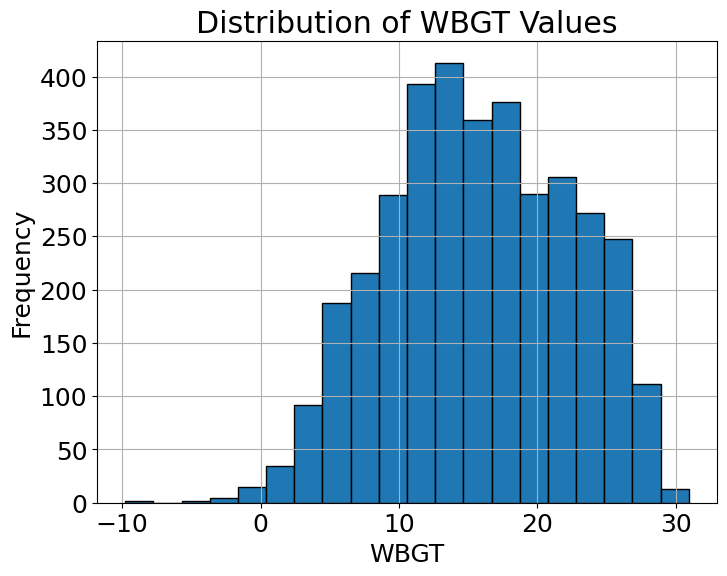

In [195]:
plt.figure(figsize=(8, 6))
plt.hist(da_proj_period_values, bins=20, edgecolor='black')  # Adjust number of bins as needed
plt.title('Distribution of WBGT Values')
plt.xlabel('WBGT')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [189]:
da_hist_period_extremes = da_hist_period[:,195,260].where(da_hist_period[:,195,260] > 27, drop=True)
da_hist_period_extremes.groupby('time.year').count()

<xarray.DataArray 'WBGT' (year: 1)> Size: 8B
array([2])
Coordinates:
    lat      float64 8B 47.37
    lon      float64 8B 2.812
  * year     (year) int64 8B 1997
Attributes:
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  128
    units:             degrees_C
    long_name:         Wet bulb globe temperature

In [190]:
da_proj_period_extremes = da_proj_period[:,195,260].where(da_proj_period[:,195,260] > 27, drop=True)
da_proj_period_extremes.groupby('time.year').count()

<xarray.DataArray 'WBGT' (year: 10)> Size: 80B
array([12,  9,  6, 22, 16,  5, 14, 13, 10, 10])
Coordinates:
    lat      float64 8B 47.37
    lon      float64 8B 2.812
  * year     (year) int64 80B 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079
Attributes:
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  128
    units:             degrees_C
    long_name:         Wet bulb globe temperature